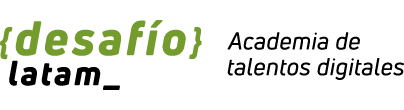

# <font color = 'green'>Solución Prueba - Modelos avanzados y redes neuronales </font>

### Carga de las librerías necesarias y datos

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import re
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import multiprocessing

from keras.layers import Embedding, Input
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import gdown

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 3000)

In [71]:
df=pd.read_csv('news1.csv')
df.sample(3)


title  \
1404   MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trump Bias May Be Suicidal   
6210  Yemeni forces fire ballistic missile at Saudi Arabia’s Jeddah airport   
5560                            Donald Trump's year of tweeting dangerously   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text  \
1404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

#### Conteo de noticias por clase

In [ ]:
df['label'].value_counts()

FAKE    3186
REAL    3154
Name: label, dtype: int64

#### División para conjunto de entrenamiento y test

In [ ]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=23)
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

#### Exploración frecuencia de palabras

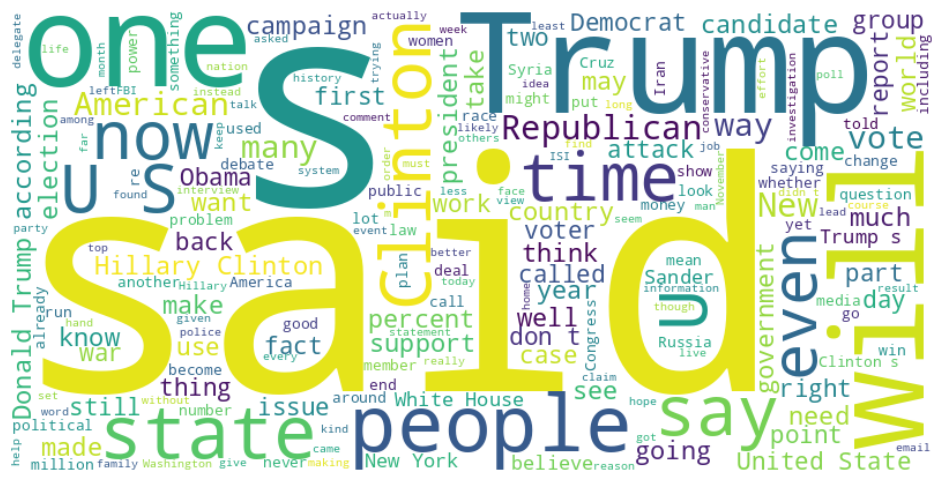

In [ ]:
opiniones = ' '.join(df_train['text'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(opiniones)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Utilizando Word Embedding from Google Embedding
https://code.google.com/archive/p/word2vec/
https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300

Los estudiantes pueden contar con el archivo 'archivo.bin', pero también pueden descargarlo de los links dados

In [ ]:
url = 'https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK'

# Nombre del archivo descargado
nombre_archivo = 'archivo.bin'

# Descargar el archivo desde Google Drive
gdown.download(url, nombre_archivo, quiet=False)

# Cargar el archivo con KeyedVectors
word2vec_model_google = KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)


Downloading...
From (original): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK
From (redirected): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK&confirm=t&uuid=b90e53ce-5112-4b47-8963-a02f91f9d8eb
To: /content/archivo.bin
100%|██████████| 3.64G/3.64G [00:51<00:00, 70.8MB/s]


#### Tokenización y padding

In [ ]:
n_secuencia = 85
num_words = 80000 # tamaño del vocabulario

X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]
tokenizer = Tokenizer(num_words=num_words, lower=True, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

# este límite de palabras se aplica cuando se pasan los tokens a sequences.

In [ ]:
# cada doc tokenizado es representado númericamente y luego se aplica el padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=n_secuencia)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=n_secuencia)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (4249, 85)
X_test.shape : (2094, 85)


#### Creación de Matriz de Embedding

In [ ]:
def get_embedding_matrix(word2vec_model, tokenizer, num_words, embedding_dim):

    num_words_ = min(num_words, len(tokenizer.word_index)) + 1
    embedding_matrix = np.zeros((num_words_, embedding_dim))
    print(num_words_)

    if isinstance(word2vec_model, Word2Vec):
        word2vec_model = word2vec_model.wv

    for word, i in tokenizer.word_index.items():
        if i >= num_words_:
            continue

        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
        else:
            embedding_matrix[i] = np.zeros(embedding_dim)

    return num_words_, embedding_matrix

In [ ]:
# El Embedding de Google usa 300 características
embedding_dim = 300

num_words, embedding_matrix = get_embedding_matrix(word2vec_model_google, tokenizer, num_words, embedding_dim)
print("Embedding Matrix Shape:", embedding_matrix.shape)

66450
Embedding Matrix Shape: (66450, 300)


### Creación de Modelo de Red Neuronal LSTM

In [ ]:
import tensorflow as tf

# Definir el modelo LSTM
def get_model_lstm():
    capa_embedding = tf.keras.layers.Embedding(input_dim=num_words,
                                output_dim=300,
                                weights=[embedding_matrix],
                                input_length=n_secuencia,
                                trainable=True)

    model = tf.keras.Sequential()
    model.add(capa_embedding)
    model.add(tf.keras.layers.LSTM(100, dropout=0.3, return_sequences=True))
    model.add(tf.keras.layers.LSTM(110, dropout=0.3, return_sequences=True))
    model.add(tf.keras.layers.LSTM(120, dropout=0.3, return_sequences=False))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Usamos 'sigmoid' para un problema binario

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Crear el modelo LSTM
training_model = get_model_lstm()
training_model.summary()

# Entrenamiento del modelo
epochs = 10
history = training_model.fit(
    X_train, y_train_encoded,
    batch_size=64,
    epochs=epochs,
    validation_data=(X_test, y_test_encoded),
    validation_split=0.1,
    verbose=1
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 85, 300)           19935000  
                                                                 
 lstm_12 (LSTM)              (None, 85, 100)           160400    
                                                                 
 lstm_13 (LSTM)              (None, 85, 110)           92840     
                                                                 
 lstm_14 (LSTM)              (None, 120)               110880    
                                                                 
 dense_8 (Dense)             (None, 16)                1936      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20301073 (77.44 MB)
Trainable params: 20

#### Predicciones

In [ ]:
yhat = training_model.predict(X_test)
yhat_class = np.where(yhat[:, 0] > 0.5, 1, 0)
y_test_true = np.where(y_test == 'REAL', 1, 0)


# Métricas asociadas a la Matriz de Confusión
print(classification_report(y_test_true , yhat_class))

66/66 [==============================] - 14s 208ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1072
           1       0.94      0.88      0.91      1022

    accuracy                           0.91      2094
   macro avg       0.92      0.91      0.91      2094
weighted avg       0.92      0.91      0.91      2094



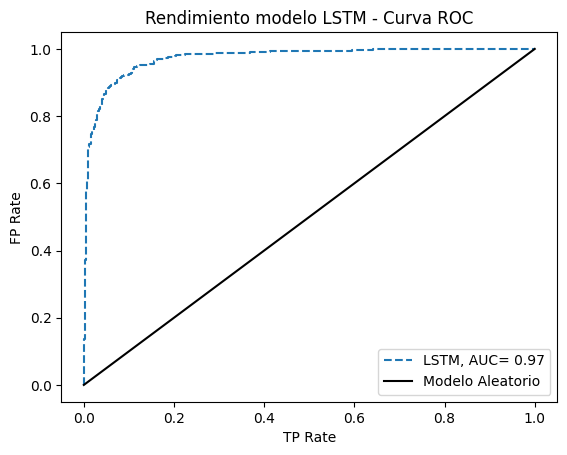

In [ ]:
# Curva ROC

fpr, tpr, _ = roc_curve(y_test_true, yhat[:, 0])
auc = roc_auc_score(y_test_true, yhat[:, 0])
plt.plot(fpr, tpr, '--', label=f'LSTM, AUC= {np.round(auc, 2)}')
plt.plot([0.0, 1.0], [0.0, 1.0], '-', color='black', label='Modelo Aleatorio')
plt.legend()
plt.title('Rendimiento modelo LSTM - Curva ROC')
plt.xlabel('TP Rate')
plt.ylabel('FP Rate')
plt.show();

### Predicciones puntuales sobre news_pred

In [ ]:
df_pred = pd.read_csv('news_pred.csv')
df_pred

title  \
0  At least 12 dead after terror attack at Paris newspaper office (+video)   
1                  World leaders' personal chefs sample Indian market fare   
2                    An Open Letter to Black South African Police Officers   
3                 Gay man finds it in himself to tolerate religious person   
4     US Spy Chief: Asking North Korea To Stop Nuke Program a ‘Lost Cause’   
5    The Devastating Consequences Of A 'Small' Rise In Global Temperatures   
6   Cost, logistics of Obama immigration plan raise concerns before launch   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
0  Gunmen stormed the offices of the satirical newspaper Charlie Hebdo on Wednesday. French President Francois Hollande called the deadly assault a terrorist attack.\n\nWhy is Angela Merkel calling for a ban on the full Islamic veil?\n\nMasked gunmen shouting "Allahu akbar!" stormed the Paris offices of a satirical newspaper Wednesday, killing 12 people including the editor and a cartoonist before escaping. It was France's deadliest t

In [ ]:
X_pred  = pad_sequences(tokenizer.texts_to_sequences(df_pred['text']) , maxlen=n_secuencia)

In [ ]:
# Predicciones
yhat = training_model.predict(X_pred)
yhat_class = np.where(yhat[:, 0] > 0.5, 1, 0)

df_pred['lbl_predict'] = yhat_class
df_pred

1/1 [==============================] - 0s 120ms/step


title  \
0  At least 12 dead after terror attack at Paris newspaper office (+video)   
1                  World leaders' personal chefs sample Indian market fare   
2                    An Open Letter to Black South African Police Officers   
3                 Gay man finds it in himself to tolerate religious person   
4     US Spy Chief: Asking North Korea To Stop Nuke Program a ‘Lost Cause’   
5    The Devastating Consequences Of A 'Small' Rise In Global Temperatures   
6   Cost, logistics of Obama immigration plan raise concerns before launch   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
0  Gunmen stormed the offices of the satirical newspaper Charlie Hebdo on Wednesday. French President Francois Hollande called the deadly assault a terrorist attack.\n\nWhy is Angela Merkel calling for a ban on the full Islamic veil?\n\nMasked gunmen shouting "Allahu akbar!" stormed the Paris offices of a satirical newspaper Wednesday, killing 12 people including the editor and a cartoonist before escaping. It was France's deadliest t

---
---

Considerar los comentarios del estudiante sobre sus resultados

### Carga de datos y análisis

In [ ]:
df2 = pd.read_csv('OnlineNewsPopularity.csv')
print(df2.shape)
df2.head()

(39644, 61)


url   timedelta  \
0    http://mashable.com/2013/01/07/amazon-instant-video-browser/       731.0   
1     http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/       731.0   
2  http://mashable.com/2013/01/07/apple-40-billion-app-downloads/       731.0   
3        http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/       731.0   
4                http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0             12.0              219.0          0.663594                1.0   
1              9.0              255.0          0.604743                1.0   
2              9.0              211.0          0.575130                1.0   
3              9.0              531.0          0.503788                1.0   
4             13.0             1072.0          0.415646                1.0   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  \
0                   0.815385         4.0              2.0        1.0   
1                   0.791946         3.0              1.0        1.0   
2                   0.663866         3.0              1.0        1.0   
3                   0.665635         9.0              0.0        1.0   
4                   0.540890        19.0             19.0       20.0   

    num_videos   average_token_length   num_keywords  \
0          0.0               4.680365            5.0   
1          0.0               4.913725            4.0   
2          0.0               4.393365            6.0   
3          0.0               4.404896            7.0   
4          0.0               4.682836            7.0   

    data_channel_is_lifestyle   data_channel_is_entertainment  \
0                         0.0                             1.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         0.0                             1.0   
4                         0.0                             0.0   

    data_channel_is_bus   data_channel_is_socmed   data_channel_is_tech  \
0                   0.0                      0.0                    0.0   
1                   1.0                      0.0                    0.0   
2                   1.0                      0.0                    0.0   
3                   0.0                      0.0                    0.0   
4                   0.0                      0.0                    1.0   

    data_channel_is_world   kw_min_min   kw_max_min   kw_avg_min   kw_min_max  \
0                     0.0          0.0          0.0          0.0          0.0   
1                     0.0          0.0          0.0          0.0          0.0   
2                     0.0          0.0          0.0          0.0          0.0   
3                     0.0          0.0          0.0          0.0          0.0   
4                     0.0          0.0          0.0          0.0          0.0   

    kw_max_max   kw_avg_max   kw_min_avg   kw_max_avg   kw_avg_avg  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

    self_reference_min_shares   self_reference_max_shares  \
0                       496.0                       496.0   
1                         0.0                         0.0   
2                       918.0                       918.0   
3                         0.0                         0.0   
4                       545.0                     16000.0   

    self_reference_avg_sharess   weekday_is_monday   weekday_is_tuesday  \
0                   496.000000                 1.0                  0.0   
1                     0.000000                 1.0                  0

Se quitan espacios en el nombre de las columnas

In [ ]:
print(df2.columns)
print()
df2.columns = [str.replace(x, ' ', '') for x in df2.columns]
print(df2.columns)

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

Se eliminan columnas que no aportan información para los modelos

In [ ]:
df2 = df2.drop(columns=['url', 'timedelta'], axis=1)
df2.head()

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.815385        4.0             2.0       1.0         0.0   
1                  0.791946        3.0             1.0       1.0         0.0   
2                  0.663866        3.0             1.0       1.0         0.0   
3                  0.665635        9.0             0.0       1.0         0.0   
4                  0.540890       19.0            19.0      20.0         0.0   

   average_token_length  num_keywords  data_channel_is_lifestyle  \
0              4.680365           5.0                        0.0   
1              4.913725           4.0                        0.0   
2              4.393365           6.0                        0.0   
3              4.404896           7.0                        0.0   
4              4.682836           7.0                        0.0   

   data_channel_is_entertainment  data_channel_is_bus  data_channel_is_socmed  \
0                            1.0                  0.0                     0.0   
1                            0.0                  1.0                     0.0   
2                            0.0                  1.0                     0.0   
3                            1.0                  0.0                     0.0   
4                            0.0                  0.0                     0.0   

   data_channel_is_tech  data_channel_is_world  kw_min_min  kw_max_min  \
0                   0.0                    0.0         0.0         0.0   
1                   0.0                    0.0         0.0         0.0   
2                   0.0                    0.0         0.0         0.0   
3                   0.0                    0.0         0.0         0.0   
4                   1.0                    0.0         0.0         0.0   

   kw_avg_min  kw_min_max  kw_max_max  kw_avg_max  kw_min_avg  kw_max_avg  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   kw_avg_avg  self_reference_min_shares  self_reference_max_shares  \
0         0.0                      496.0                      496.0   
1         0.0                        0.0                        0.0   
2         0.0                      918.0                      918.0   
3         0.0                        0.0                        0.0   
4         0.0                      545.0                    16000.0   

   self_reference_avg_sharess  weekday_is_monday  weekday_is_tuesday  \
0                  496.000000                1.0                 0.0   
1                    0.000000                1.0                 0.0   
2                  918.000000                1.0                 0.0   
3                    0.000000                1.0                 0.0   
4                 3151.157895                1.0                 0.0   

   weekday_is_wednesday  weekday_is_thursday  weekday_is_friday  \
0                   0.0                  0.0                0.0   
1                   0.0                  0.0                0.0   
2                   0.0                  0.0                0.0   
3                   0.0                  0.0                0.0   
4                   0.0                  0.0                0.0   

   weekday

Se revisan estadísticos para las variables numéricas

In [ ]:
df2.describe()

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
count    39644.000000      39644.000000     39644.000000      39644.000000   
mean        10.398749        546.514731         0.548216          0.996469   
std          2.114037        471.107508         3.520708          5.231231   
min          2.000000          0.000000         0.000000          0.000000   
25%          9.000000        246.000000         0.470870          1.000000   
50%         10.000000        409.000000         0.539226          1.000000   
75%         12.000000        716.000000         0.608696          1.000000   
max         23.000000       8474.000000       701.000000       1042.000000   

       n_non_stop_unique_tokens     num_hrefs  num_self_hrefs      num_imgs  \
count              39644.000000  39644.000000    39644.000000  39644.000000   
mean                   0.689175     10.883690        3.293638      4.544143   
std                    3.264816     11.332017        3.855141      8.309434   
min                    0.000000      0.000000        0.000000      0.000000   
25%                    0.625739      4.000000        1.000000      1.000000   
50%                    0.690476      8.000000        3.000000      1.000000   
75%                    0.754630     14.000000        4.000000      4.000000   
max                  650.000000    304.000000      116.000000    128.000000   

         num_videos  average_token_length  num_keywords  \
count  39644.000000          39644.000000  39644.000000   
mean       1.249874              4.548239      7.223767   
std        4.107855              0.844406      1.909130   
min        0.000000              0.000000      1.000000   
25%        0.000000              4.478404      6.000000   
50%        0.000000              4.664082      7.000000   
75%        1.000000              4.854839      9.000000   
max       91.000000              8.041534     10.000000   

       data_channel_is_lifestyle  data_channel_is_entertainment  \
count               39644.000000                   39644.000000   
mean                    0.052946                       0.178009   
std                     0.223929                       0.382525   
min                     0.000000                       0.000000   
25%                     0.000000                       0.000000   
50%                     0.000000                       0.000000   
75%                     0.000000                       0.000000   
max                     1.000000                       1.000000   

       data_channel_is_bus  data_channel_is_socmed  data_channel_is_tech  \
count         39644.000000            39644.000000          39644.000000   
mean              0.157855                0.058597              0.185299   
std               0.364610                0.234871              0.388545   
min               0.000000                0.000000              0.000000   
25%               0.000000                0.000000              0.000000   
50%               0.000000                0.000000              0.000000   
75%               0.000000                0.000000              0.000000   
max               1.000000                1.000000              1.000000   

       data_channel_is_world    kw_min_min     kw_max_min    kw_avg_min  \
count           39644.000000  39644.000000   39644.000000  39644.000000   
mean                0.212567     26.106801    1153.951682    312.366967   
std                 0.409129     69.633215    3857.990877    620.783887   
min                 0.000000     -1.000000       0.000000     -1.000000   
25%                 0.000000     -1.000000     445.000000    141.750000   
50%                 0.000000     -1.000000     660.000000    235.500000   
75%                 0.000000      4.000000    1000.000000    357.000000   
max                 1.000000    377.000000  298400.000000  42827.857143   

          kw_min_max     kw_max_max     kw_avg_max    kw_min_avg  \
count   39644.000000   3964

#### Revisar si tenemos o no valores ausentes

In [ ]:
serie_aux_ = df2.apply(lambda x: np.sum(x.isnull()), axis=0)

print(f'Cantidad de variables con valores ausentes: {len(serie_aux_[serie_aux_ > 0])}')
print()
if len(serie_aux_[serie_aux_>0]) > 0:
    print(serie_aux_)

Cantidad de variables con valores ausentes: 0



### Busqueda de valores Outliers para variable objetivo shares







Text(0.5, 1.0, 'shares antes de quitar outliers')

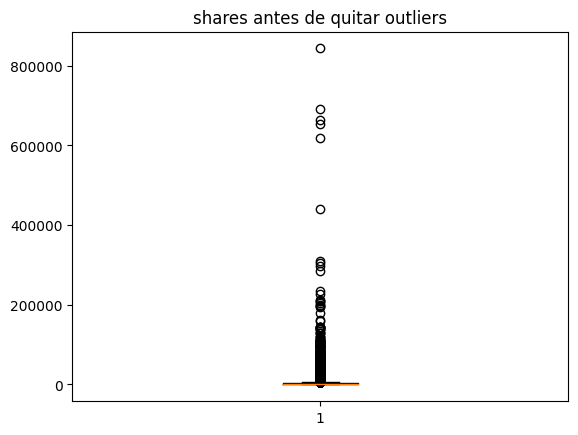

In [ ]:
plt.boxplot(df2['shares'])
plt.title('shares antes de quitar outliers')

Se descartan outlier mayores a 3 std

N-outliers drop: (308,)


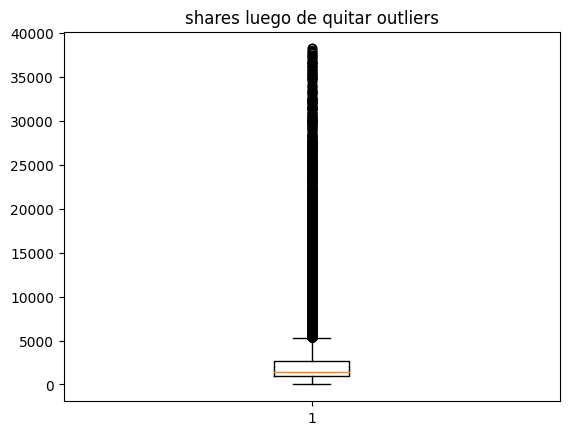

In [ ]:
z_scores = (df2['shares']-np.mean(df2['shares']))/np.std(df2['shares'])
frontera = 3
idx_outliers = (z_scores[np.abs(z_scores) > frontera].index).to_numpy()
print(f'N-outliers drop: {idx_outliers.shape}')

plt.boxplot(df2[~df2.index.isin(idx_outliers)]['shares'])
df3 = df2[~df2.index.isin(idx_outliers)]
plt.title('shares luego de quitar outliers');

In [ ]:
df3['shares'].describe()

count    39336.000000
mean      2755.416260
std       3949.651794
min          1.000000
25%        942.000000
50%       1400.000000
75%       2700.000000
max      38200.000000
Name: shares, dtype: float64

Se eliminas las variables con correlaciones mayores a un umbral (0.7)

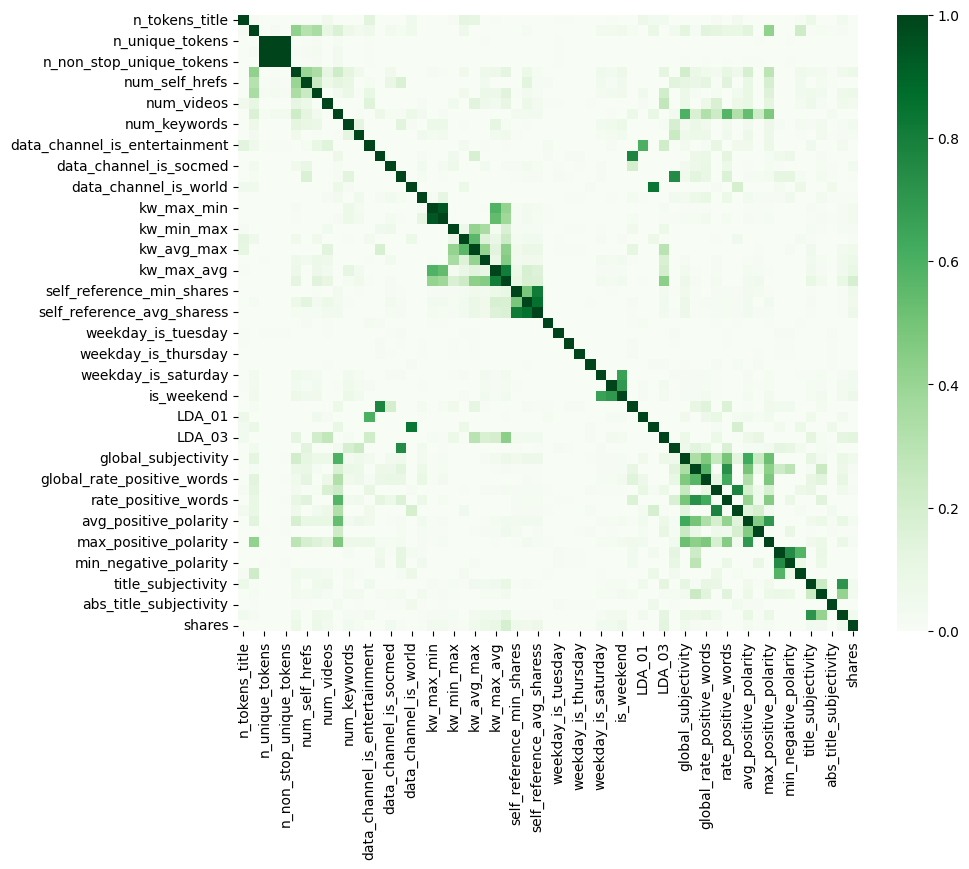

In [ ]:
# Heatmap antes de eliminar variables con alta correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df3.corr(), vmin=0, vmax=1, cmap='Greens');

var to drop: 30


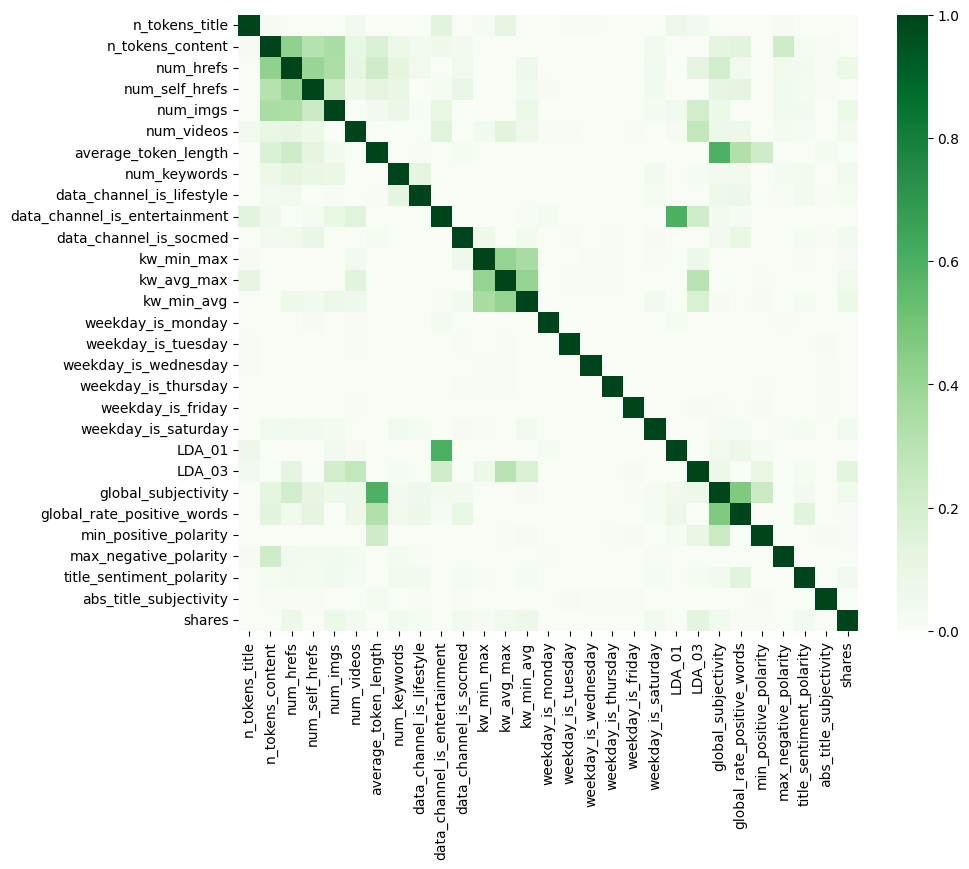

In [ ]:
frontera = .7
matrix_corr = (df3.drop(columns=['shares'], axis=1).corr().abs()).unstack().sort_values(kind="quicksort")
serie_corr_tmp = matrix_corr[(matrix_corr != 1.0) & (matrix_corr > frontera)].sort_values(ascending=False)
lst_va_corr_drop = list(set([x[0] for x in serie_corr_tmp.index]))
print(f'var to drop: {len(lst_va_corr_drop)}')
df4 = df3.drop(columns=lst_va_corr_drop, axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(df4.corr(), vmin=0, vmax=1, cmap='Greens');

In [ ]:
df4.head()

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
0            12.0             219.0        4.0             2.0       1.0   
1             9.0             255.0        3.0             1.0       1.0   
2             9.0             211.0        3.0             1.0       1.0   
3             9.0             531.0        9.0             0.0       1.0   
4            13.0            1072.0       19.0            19.0      20.0   

   num_videos  average_token_length  num_keywords  data_channel_is_lifestyle  \
0         0.0              4.680365           5.0                        0.0   
1         0.0              4.913725           4.0                        0.0   
2         0.0              4.393365           6.0                        0.0   
3         0.0              4.404896           7.0                        0.0   
4         0.0              4.682836           7.0                        0.0   

   data_channel_is_entertainment  data_channel_is_socmed  kw_min_max  \
0                            1.0                     0.0         0.0   
1                            0.0                     0.0         0.0   
2                            0.0                     0.0         0.0   
3                            1.0                     0.0         0.0   
4                            0.0                     0.0         0.0   

   kw_avg_max  kw_min_avg  weekday_is_monday  weekday_is_tuesday  \
0         0.0         0.0                1.0                 0.0   
1         0.0         0.0                1.0                 0.0   
2         0.0         0.0                1.0                 0.0   
3         0.0         0.0                1.0                 0.0   
4         0.0         0.0                1.0                 0.0   

   weekday_is_wednesday  weekday_is_thursday  weekday_is_friday  \
0                   0.0                  0.0                0.0   
1                   0.0                  0.0                0.0   
2                   0.0                  0.0                0.0   
3                   0.0                  0.0                0.0   
4                   0.0                  0.0                0.0   

   weekday_is_saturday    LDA_01    LDA_03  global_subjectivity  \
0                  0.0  0.378279  0.041263             0.521617   
1                  0.0  0.050047  0.050101             0.341246   
2                  0.0  0.033334  0.033334             0.702222   
3                  0.0  0.419300  0.028905             0.429850   
4                  0.0  0.028794  0.028572             0.513502   

   global_rate_positive_words  min_positive_polarity  max_negative_polarity  \
0                    0.045662               0.100000              -0.200000   
1                    0.043137               0.033333              -0.100000   
2                    0.056872               0.100000              -0.133333   
3                    0.041431               0.136364              -0.166667   
4                    0.074627               0.033333              -0.050000   

   title_sentiment_polarity  abs_title_subjectivity  shares  
0                 -0.187500                0.000000     593  
1                  0.000000                0.500000     711  
2                  0.000000                0.500000    1500  
3                  0.000000                0.500000    1200  
4                  0.136364                0.045455     505

### Selección de variables, análisis y normalización



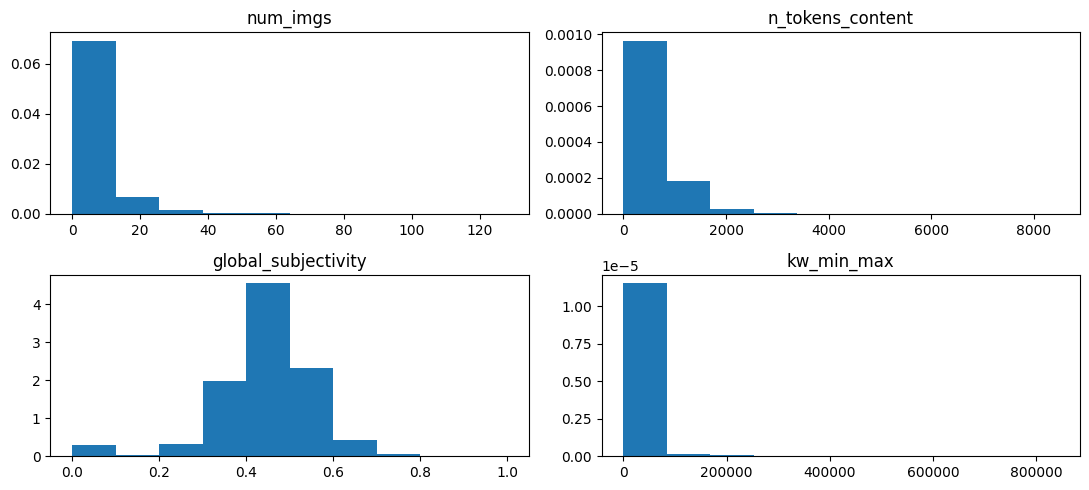

In [ ]:
lst_va = ['num_imgs', 'n_tokens_content', 'global_subjectivity', 'kw_min_max']
plt.figure(figsize=(11, 5))

for i, va_ in enumerate(lst_va):
    plt.subplot(2, 2, i+1)
    plt.hist(df4[va_], density=True)
    plt.title(va_)
plt.tight_layout();

Escalar y dividir los datos en conjunto de entrenamiento y test

In [ ]:
X = df4.drop(columns=['shares'], axis=1)
y = df4['shares']

sscaler = StandardScaler()
X_ss = sscaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=.33, random_state=23)

### Primer Modelo RandomForest

In [ ]:
param_grid = {
    'n_estimators': np.linspace(100, 300, 10, dtype='int16'),
    'max_depth': np.linspace(2, 15, 10, dtype='int16'),
    'max_features': ['sqrt', 'log2']
}

grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
grid_rfr.fit(X_train, y_train)
print(grid_rfr.best_params_)

{'max_depth': 13, 'max_features': 'log2', 'n_estimators': 300}


In [ ]:
yhat_rfr = grid_rfr.best_estimator_.predict(X_test)
rmse_rfr = mean_squared_error(y_test, yhat_rfr, squared=False)
mae_rfr = mean_absolute_error(y_test, yhat_rfr)
print(f'RMSE RFR: {rmse_rfr}')
print(f'MAE RFR : {mae_rfr}')

RMSE RFR: 3841.2054313433873
MAE RFR : 2135.421268416361


### Modelo Fully Conected

In [ ]:
def get_model_fffc (n_neurons=[], activation='relu', dropout_rate=.35, n_features=0):
    model = Sequential()

    model.add(Input(shape=(n_features,)))

    for nn in n_neurons:
        model.add(Dense(nn, activation=activation, use_bias=True, bias_initializer='glorot_uniform', kernel_initializer='glorot_normal', kernel_constraint=MaxNorm(3)))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(1, activation='linear', kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', use_bias=True, kernel_constraint=MaxNorm(3)))
    #model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.05, momentum=0.6), metrics=['mean_squared_error'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

    return model

In [ ]:
fffc_model = get_model_fffc(n_neurons=[500, 350], n_features=X_train.shape[1])

In [ ]:
fffc_model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=[X_test, y_test], verbose=1)

Epoch 1/250
824/824 [==============================] - 7s 8ms/step - loss: 16888378.0000 - mean_squared_error: 16888378.0000 - val_loss: 15163672.0000 - val_mean_squared_error: 15163672.0000
Epoch 2/250
824/824 [==============================] - 10s 12ms/step - loss: 15010962.0000 - mean_squared_error: 15010962.0000 - val_loss: 15004202.0000 - val_mean_squared_error: 15004202.0000
Epoch 3/250
824/824 [==============================] - 5s 6ms/step - loss: 14933400.0000 - mean_squared_error: 14933400.0000 - val_loss: 15008980.0000 - val_mean_squared_error: 15008980.0000
Epoch 4/250
824/824 [==============================] - 7s 9ms/step - loss: 14870891.0000 - mean_squared_error: 14870891.0000 - val_loss: 14973589.0000 - val_mean_squared_error: 14973589.0000
Epoch 5/250
824/824 [==============================] - 5s 6ms/step - loss: 14879840.0000 - mean_squared_error: 14879840.0000 - val_loss: 14953114.0000 - val_mean_squared_error: 14953114.0000
Epoch 6/250
824/824 [======================

In [ ]:
yhat_fffc = fffc_model.predict(X_test)
rmse_fffc = mean_squared_error(y_test, yhat_fffc, squared=False)
mae_fffc = mean_absolute_error(y_test, yhat_fffc)
print(f'RMSE RFR: {rmse_fffc}')
print(f'MAE RFR : {mae_fffc}')

406/406 [==============================] - 1s 2ms/step
RMSE RFR: 4818.433112891214
MAE RFR : 2762.9138587211005


### 3er Modelo XGBoosting

In [ ]:
%%time
param_grid = {
    'n_estimators': [100, 120, 150, 200, 300],
    'learning_rate': [0.008, 0.07, 0.009, 0.01, 0.02],
    'subsample': np.linspace(0.05, 1, 5),
    'scale_pos_weight': np.linspace(0.8, 0.9, 2)
}

grid_xgb = GridSearchCV(xgb.XGBRegressor(random_state=23), param_grid=param_grid, cv=5, n_jobs=-1)
grid_xgb.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

CPU times: user 24.1 s, sys: 3.39 s, total: 27.5 s
Wall time: 21min 43s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=23, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.008, 0.07, 0.009, 0.01, 0.02],
                         'n_estimators': [100, 120, 150, 200, 300],
                         'scale_pos_weight': array([0.8, 0.9]),
                         'subsample': array([0.05  , 0.2875, 0.525 , 0.7625, 1.    ])})

In [ ]:
print(grid_xgb.best_params_)
yhat_xgb = grid_xgb.best_estimator_.predict(X_test)

rmse_xgb = mean_squared_error(y_test, yhat_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, yhat_xgb)
print(f'RMSE RFR: {rmse_xgb}')
print(f'MAE RFR : {mae_xgb}')


{'learning_rate': 0.009, 'n_estimators': 300, 'scale_pos_weight': 0.8, 'subsample': 0.7625}
RMSE RFR: 3836.936834397016
MAE RFR : 2118.9969278548183


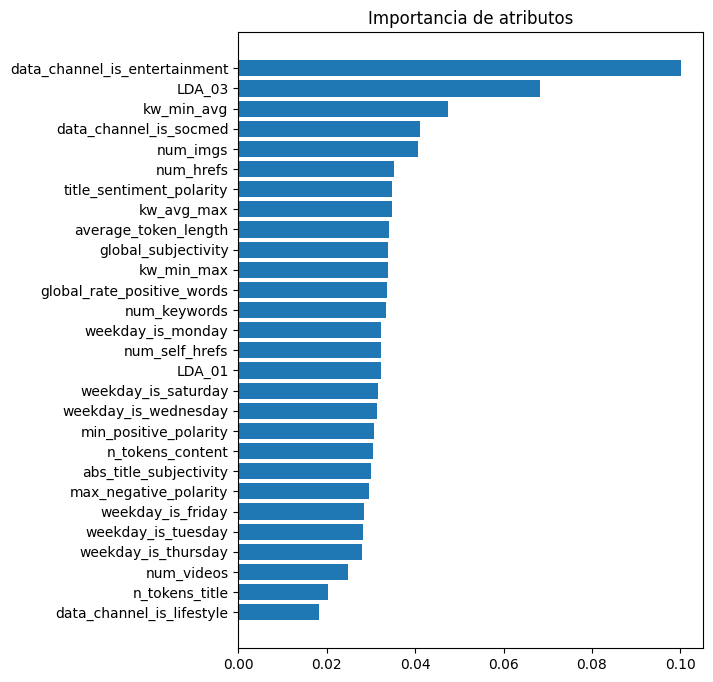

In [ ]:
# Importancia de las características

df_imp = pd.DataFrame({
    'feature': grid_xgb.best_estimator_.feature_names_in_,
    'importance': grid_xgb.best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=True)

plt.figure(figsize=(6, 8))
plt.barh(y=df_imp['feature'], width=df_imp['importance'])
plt.title('Importancia de atributos')
plt.show()

### Construcción de Bagging con modelos heterogéneos

In [ ]:
import util_bagging as ubagging

###
# Ponderaciones
###

# LinearRegression                    38.9%
# DecisionTreeRegressor(max_depth=2)  27.8%
# DecisionTreeRegressor()             22.2%
# SVR(kernel='rbf')                   11.1%

estimators = [
    LinearRegression(),
    LinearRegression(),
    LinearRegression(),
    LinearRegression(),
    LinearRegression(),
    LinearRegression(),
    LinearRegression(),
    DecisionTreeRegressor(max_depth=2),
    DecisionTreeRegressor(max_depth=2),
    DecisionTreeRegressor(max_depth=2),
    DecisionTreeRegressor(max_depth=2),
    DecisionTreeRegressor(max_depth=2),
    DecisionTreeRegressor(),
    DecisionTreeRegressor(),
    DecisionTreeRegressor(),
    DecisionTreeRegressor(),
    SVR(kernel='rbf'),
    SVR(kernel='rbf'),
]

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_s = pd.Series(y_train).reset_index(drop=True)
trained_model, resultados, yhat_bggh, idx_oob = ubagging.bagging_het(X_train_df, y_train_s, 200, estimators, X_test_df)

In [ ]:
rmse_bggh = mean_squared_error(y_test, yhat_bggh, squared=False)
mae_bggh = mean_absolute_error(y_test, yhat_bggh)
print(f'RMSE BGGH: {rmse_bggh}')
print(f'MAE BGGH : {mae_bggh}')

RMSE BGGH: 4928.3125304443865
MAE BGGH : 2236.78060241892


#### Consolidación de resultados

In [ ]:
df_result_final = pd.DataFrame({
    'modelo': ['Random Forest', 'Red Neuronal FC', 'XGBoosting', 'Bagging Het.'],
    'rmse': [np.round(x, 2) for x in [rmse_rfr, rmse_fffc, rmse_xgb, rmse_bggh]],
    'mae': [np.round(x, 2) for x in [mae_rfr, mae_fffc, mae_xgb, mae_bggh]]
})

df_result_final.sort_values(by='rmse', ascending=True)

modelo     rmse      mae
2       XGBoosting  3836.94  2119.00
0    Random Forest  3841.21  2135.42
1  Red Neuronal FC  4818.43  2762.91
3     Bagging Het.  4928.31  2236.78

Las conclusiones dependen del estudiante.